In [1]:
import Pkg

Pkg.add("MLDataUtils")
Pkg.add("DelimitedFiles")
Pkg.add("Flux")
Pkg.add("DataFrames")
Pkg.add("LaTeXStrings")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [2]:
using ImageCore
using MLDatasets
using LinearAlgebra
using DelimitedFiles
using Flux
using MLDataUtils
using Plots
using Printf
using Statistics
using DataFrames
using LaTeXStrings
using StatsBase

In [3]:
train_x, train_y = MNIST.traindata()
test_x, test_y = MNIST.testdata()

train_x = convert(Array{Float64, 3}, permutedims(train_x, [3, 2, 1]))
test_x = convert(Array{Float64, 3}, permutedims(test_x, [3, 2, 1]))

train_y = train_y .+ 1
test_y = test_y .+ 1

no_samples = size(train_x)[1]
no_pixels = size(train_x)[2]
no_labels = length(unique(train_y))[1];

In [4]:
# Given we are working with an MLP, we will flatten the vectors

train_x = reduce(vcat, [Matrix([train_x[i, :, :]...]') for i in 1:no_samples])
test_x = reduce(vcat, [Matrix([test_x[i, :, :]...]') for i in 1:size(test_x)[1]]);

In [5]:
size(train_x)

(60000, 784)

In [6]:
MNIST.convert2image(MNIST.traintensor(1))

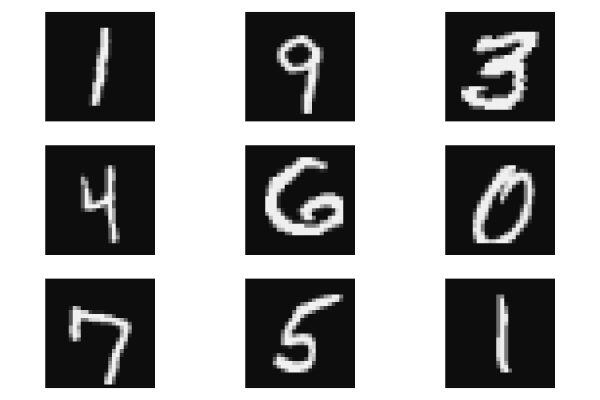

In [7]:
random_samples = rand(1:no_samples, 9);
plt = plot(layout = (3, 3), aspect_ratio = :equal, axis = false)

for (i, sample) in enumerate(random_samples)
    heatmap!(plt, 
        reshape(train_x[sample, :], no_pixels, no_pixels), 
        subplot = i, 
        yflip = true, 
        color = :grays, 
        colorbar = false, 
        axis = nothing)
end

display(plt)

In [8]:
function train_test_split(indices, shuffle, split)
    index_list = shuffle == 1 ? shuffleobs(indices) : deepcopy(indices)
    return splitobs(index_list, at = split)
end

train_test_split (generic function with 1 method)

# Random Forest

In [9]:
#Define a binary tree node

mutable struct Node
    left::Union{Node, Nothing}
    right::Union{Node, Nothing}
    attr::Dict # attributes
end

#Define a fucntion to construct an empty node

function Node()
    Node(nothing, nothing, Dict())
end

#Define a binary Decision Tree

mutable struct DecisionTreeClassifier
    root::Node
end

#Finally we define a the Random Forest

mutable struct RandomForest
    trees::AbstractVector{DecisionTreeClassifier}
end

#We define the following helper functions

is_leaf(node::Node) = node.left === nothing && node.right === nothing
majority_vote(classes::AbstractVector{Int64}) = findmax(countmap(classes))[2]
dict2array(dict) = collect(values(dict)) # create array from values of dict

#Define a function to return the feature index and threshold of the best split in the tree based on the Gini index

function find_best_split(X::Matrix{Float64}, y::AbstractVector{Int64}, n_features_select::Int64)

    n_samples, n_features = size(X)

    # if we have only one sample we cannot perform a split
    if n_samples <= 1
        return nothing, nothing
    end

    # count the number of samples in each class
    class_counts_base = countmap(y)

    # calculate Gini for a no split
    best_gini = 1 - sum((dict2array(class_counts_base) / n_samples).^2)
    best_index, best_threshold = nothing, nothing

    # find best split from randomly selected features
    for index_feature in sample(1:n_features, n_features_select; replace=false)

        # sort X and y
        indices_sort = sortperm(X[:, index_feature])
        X_sorted = X[indices_sort, :]
        y_sorted = y[indices_sort]

        # count the number of samples in each class in the left / right part of the split
        class_counts_left = Dict(keys(class_counts_base) .=> 0)
        class_counts_right = copy(class_counts_base)

        # iterate over all possible split indices for the given selected feature
        for index_sample in 1:n_samples-1

            # update number of samples in each class
            class = y_sorted[index_sample]
            class_counts_left[class] += 1
            class_counts_right[class] -= 1

            # if current x and the next sample are the same, skip
            x = X_sorted[index_sample, index_feature]
            x_next = X_sorted[index_sample + 1, index_feature]
            if x == x_next
                continue
            end

            # use the midpoint between current and next sample as threshold
            threshold = (x + x_next) / 2

            # calculate the Gini
            gini_left = 1 - sum((dict2array(class_counts_left) / index_sample).^2) 
            gini_right = 1 - sum((dict2array(class_counts_right) / (n_samples - index_sample)).^2) 
            gini = (index_sample * gini_left + (n_samples - index_sample) * gini_right) / n_samples

            # if we found a new best split, save it
            if best_gini > gini
                best_gini = gini
                best_index = index_feature
                best_threshold = threshold
            end
        end
    end

    return best_index, best_threshold
end

find_best_split (generic function with 1 method)

In [10]:
function DecisionTreeClassifier(X::Matrix{Float64}, y::AbstractVector{Int64}, n_features_select::Int64, max_depth::Int64)

    function _grow_tree!(node::Node, X::Matrix{Float64}, y::AbstractVector{Int64}, depth::Int64)

        # get prediction for current node using majority vote
        node.attr["predicted_class"] = majority_vote(y) 

        # if we reached the maximum depth, do nothing
        if depth == max_depth
            return
        end

        best_feature, best_threshold = find_best_split(X, y, n_features_select)

        # if there is no better split, do nothing
        if best_feature === nothing
            return
        end

        # store split results
        node.attr["best_feature"] = best_feature
        node.attr["best_threshold"] = best_threshold

        # find the left and right datasets
        left_indices = findall(X[:, best_feature] .< best_threshold)
        right_indices = findall(X[:, best_feature] .>= best_threshold)

        # recursively grow tree
        node.left = Node()
        node.right = Node()
        _grow_tree!(node.left, X[left_indices, :], y[left_indices], depth+1)
        _grow_tree!(node.right, X[right_indices, :], y[right_indices], depth+1)

    end

    root = Node()
    _grow_tree!(root, X, y, 0)

    return DecisionTreeClassifier(root)

end


function predict(tree::DecisionTreeClassifier, x::AbstractVector{Float64})
    node = tree.root
    while !is_leaf(node)
        if x[node.attr["best_feature"]] < node.attr["best_threshold"]
            node = node.left
        else
            node = node.right
        end
    end
    return node.attr["predicted_class"]
end

predict (generic function with 1 method)

In [18]:
function RandomForest(n_estimators::Int64, n_samples::Int64, n_features_select::Int64, max_depth::Int64, X::Matrix{Float64}, y::AbstractVector{Int64})

    trees = DecisionTreeClassifier[]

    @Threads.threads for i in 1:n_estimators
        println("Growing $i / $n_estimators trees ...")
        IJulia.clear_output(true)
        indices_bootstrap = sample(1:length(y), n_samples)
        tree = DecisionTreeClassifier(X[indices_bootstrap, :], y[indices_bootstrap], n_features_select, max_depth)
        push!(trees, tree)
    end

    return RandomForest(trees)
end


#Function to predict the class of a forest

function predict(rf::RandomForest, x::AbstractVector{Float64})
    return majority_vote([predict(tree, x) for tree in rf.trees])
end
    
function predict(rf::RandomForest, X::Matrix{Float64})
    return [predict(rf, x) for x in eachrow(X)]
end


#Calculate the maximum depth of a tree

function depth(tree::DecisionTreeClassifier)
    function _depth(node::Node)
        if is_leaf(node)
            return 0
        else
            return max(_depth(node.left), _depth(node.right)) + 1
        end
    end
    return _depth(tree.root)
end

accuracy(rf::RandomForest, X::Matrix{Float64}, y::Vector{Int64}) = 100 * (sum(y .== predict(rf, X)) / length(y))

accuracy (generic function with 3 methods)

In [ ]:
train_idx, val_idx = train_test_split(1:no_samples, 1, 0.8)
X_train, X_val, y_train, y_val = train_x[train_idx, :], train_x[val_idx, :], train_y[train_idx], train_y[val_idx]

rf = RandomForest(100, length(y_train), round(Int64, 0.1 * no_pixels), 20, X_train, Int.(y_train))

In [23]:
train_acc = accuracy(rf, X_train, y_train)
val_acc = accuracy(rf, X_val, y_val)

@show train_acc, val_acc;

(train_acc, val_acc) = (97.7, 93.55)


In [24]:
test_acc = accuracy(rf, test_x, test_y)

93.87